In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import glob, os, sys, time
sys.path = ['your_path/gluon-ts/src/'] + sys.path
import pandas as pd
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import math
import properscoring as ps
from scipy.stats import norm
from gluonts.evaluation.backtest import make_evaluation_predictions
import datetime
import sunrise

In [2]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

In [3]:
def replace_missing(variable):
    indices = np.where(variable==-9999)
    variable = variable.astype('float')
    variable[indices] = np.NaN
    return variable

In [252]:
path_eco = "path_to_your_data"
prepared_fluxnet_site_name = "your_prepared_fluxnet_site.npz"
eco_data = np.load(path_eco + prepared_fluxnet_site_name)

eco_data_all = np.load(path_eco + prepared_fluxnet_site_name)
N = len(eco_data['arr_0']) + len(eco_data['arr_1'])
T = 48*7 #one week of half-hourly data
prediction_length = 1*48 #one day of half-hourly data

dataset_eco_1 = np.concatenate([eco_data['arr_0'], eco_data['arr_1']]) #training data

# note the indices of each variable

Rg = dataset_eco_1[:,:,0]
temperature = dataset_eco_1[:,:,1]
Reco_night = dataset_eco_1[:,:,2]
GPP_night = dataset_eco_1[:,:,3]
NEE = dataset_eco_1[:,:,5]
PPT = dataset_eco_1[:,:,6]
VPD = dataset_eco_1[:,:,7]

freq = "30min"
start = pd.Timestamp("07-01-2001", freq=freq)

# chosen_sample = 23
normalized_fl_resp = (dataset_eco_1[:,:,8]-np.mean(dataset_eco_1[:,:,8])) / np.std(dataset_eco_1[:,:,8])

normalized_temp = (dataset_eco_1[:,:,1]-np.mean(dataset_eco_1[:,:,1])) / np.std(dataset_eco_1[:,:,1])

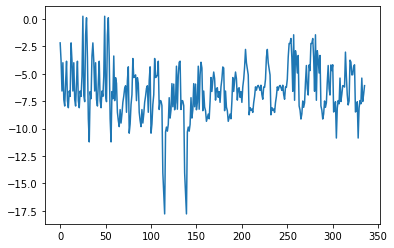

In [255]:
# creating NEE_day variable by doubling the daytime values of half-hourly NEE since covariate vectors must not have missing values

NEE_daytime_shifted = np.copy(NEE)
NEE_daytime_train_shifted[:,:12] = np.copy(NEE[:,12:24])

for i in range(24):
    if NEE[:,12+i::48].shape[1] <= NEE_daytime_shifted[:,36+i::48].shape[1]:
        NEE_daytime_shifted[:,36+i::48] = np.copy(NEE[:,12+i::48])
    else:
        NEE_daytime_shifted[:,36+i::48] = np.copy(NEE[:,12+i:-48:48])
        
plt.plot(NEE_daytime_shifted[0,:])

In [256]:
#adding NEE_day to the dataset
dataset_eco_1_and_daytimeNEE = np.concatenate([dataset_eco_1, NEE_daytime_shifted[:,:,np.newaxis]], axis=2)

#(N, T, num_var) for N samples of length T
dataset_eco_1_and_daytimeNEE[:,:,:].shape

(480, 336, 12)

In [7]:
from gluonts.dataset.common import ListDataset, MetaData
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset([{'target': x[:,2], 'start': start,'feat_static_cat' : [i], 'feat_dynamic_real' : x[:,[1]].T} #None instead of x[:,[1]].T for no covariate vectors 
                       for i, x in enumerate(dataset_eco_1_and_daytimeNEE[:, :-prediction_length])],
                       freq=freq, one_dim_target=True)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset([{'target': x[:,2], 'start': start, 'feat_static_cat' : [i], 'feat_dynamic_real' : x[:,[1]].T} #None instead of x[:,[1]].T for no covariate vectors 
                      for i, x in enumerate(dataset_eco_1_and_daytimeNEE[:, :])],
                      freq=freq, one_dim_target=True)

In [151]:
#num_batches_per_epoch x epochs x batch_size / dataset_size is equal to the number of passes over
#the dataset (or epochs in the standard deep learning terminology)
import gluonts.distribution.lds

bs = 32
estimator = DeepStateEstimator(
    prediction_length=prediction_length,
    cardinality=[len(train_ds)],
    num_layers=2,
    num_cells=40,
    cell_type='lstm',
    dropout_rate=0.1,
    use_feat_dynamic_real=True,
    add_trend=False,
    num_periods_to_train=4,
    freq=freq,
    time_features = None,
    ),
    trainer=Trainer(ctx="cpu",
                    batch_size=bs,
                    epochs=600, 
                    learning_rate=1e-4,
                    patience=50,
                    num_batches_per_epoch=len(train_ds)//bs
                   )
)

In [152]:
predictor = estimator.train(train_ds)

  0%|          | 0/5 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 5/5 [00:14<00:00,  2.88s/it, epoch=600/600, avg_epoch_loss=-.77] 


In [154]:
# save the trained model
from pathlib import Path
predictor.serialize(Path("predictor_parameters_path"))

In [200]:
#loads it back
from pathlib import Path
from gluonts.model.predictor import Predictor

predictor = Predictor.deserialize(Path("predictor_parameters_path"))

In [201]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

In [202]:
forecasts = list(tqdm(forecast_it, total=len(test_ds)))
tss = list(ts_it)

100%|██████████| 180/180 [00:46<00:00,  3.87it/s]


In [18]:
from gluonts.dataset.common import ListDataset, MetaData
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

#load fluxnet NEE
train_ds_1 = ListDataset([{'target': x[:,5], 'start': start,'feat_static_cat' : [i], 'feat_dynamic_real' : x[:,[5]].T}
                        for i, x in enumerate(dataset_eco_1[:, :-prediction_length])],
                        freq=freq, one_dim_target=True)
# load fluxnet Reco
train_ds_2 = ListDataset([{'target': x[:,8], 'start': start,'feat_static_cat' : [i], 'feat_dynamic_real' : x[:,[8]].T}
                       for i, x in enumerate(dataset_eco_1[:, :-prediction_length])],
                       freq=freq, one_dim_target=True)

# test dataset: use the whole dataset, add "target" and "start" fields
test_ds_1 = ListDataset([{'target': x[:,5], 'start': start, 'feat_static_cat' : [i], 'feat_dynamic_real' : x[:,[5]].T}
                       for i, x in enumerate(dataset_eco_1[:, :])],
                       freq=freq, one_dim_target=True)
test_ds_2 = ListDataset([{'target': x[:,8], 'start': start, 'feat_static_cat' : [i], 'feat_dynamic_real' : x[:,[8]].T}
                        for i, x in enumerate(dataset_eco_1[:, :])],
                        freq=freq, one_dim_target=True)

tss_baseline = list(ts_it_1)

tss_baseline_NEE = list(ts_it_2)

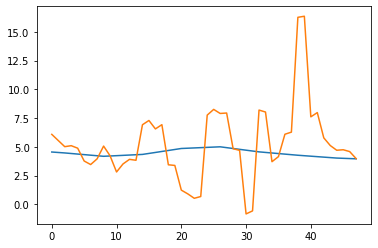

In [12]:
from gluonts.model.forecast import SampleForecast

#creating forecast out of fluxnet Reco for plotting
num_samples=dataset_eco_1_and_daytimeNEE[:,-prediction_length:,8].shape[0]
fluxnet_Reco_forecast = []
start_1 = pd.Timestamp("07-07-2001", freq=freq)
for i in range(num_samples):
    fluxnet_Reco_forecast += [SampleForecast(dataset_eco_1_and_daytimeNEE[i:i+1,-prediction_length:,8], start_1, freq)]
plt.plot(fluxnet_Reco_forecast[0].samples[0])
plt.plot(forecasts[0].samples[0])

In [19]:
def plot_prob_forecasts(tss_baseline_reco, tss_baseline_NEE, forecasts, index):
    plot_length = 1*48
    prediction_intervals = (50.0, 90.0)
    legend = ["Reichstein", "FLUXNET NEE", "DeepState median"] + [f"{k}% RECO prediction interval" for k in prediction_intervals][::-1]
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    (tss_baseline_reco[index])[-plot_length:].plot(ax=ax)
    (tss_baseline_NEE[index])[-plot_length:].plot(ax=ax)
    (forecasts[index]).plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="lower right")

#     plt.savefig(path + 'forecast.svg')
    plt.show()

49


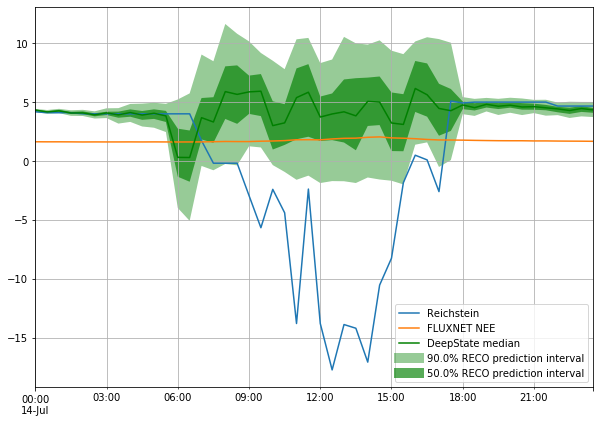

50


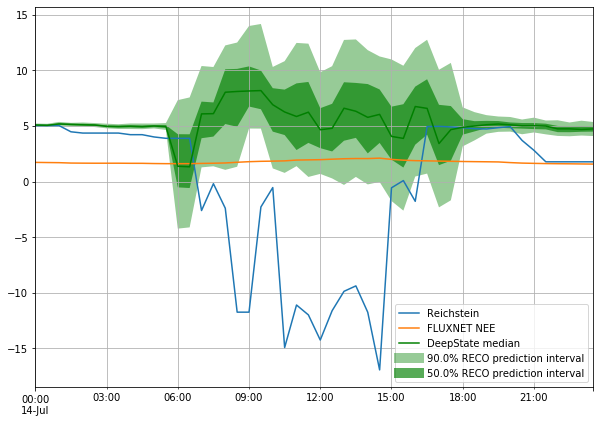

51


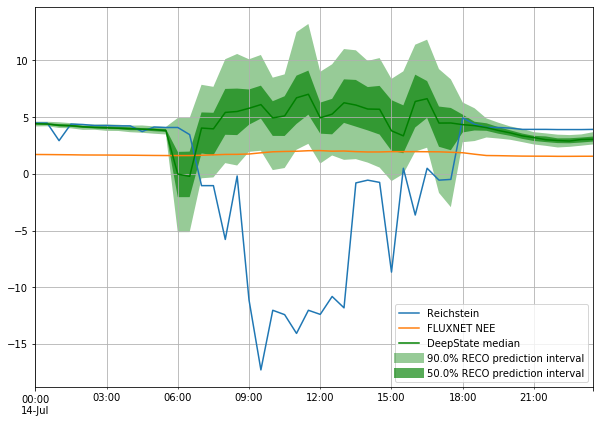

52


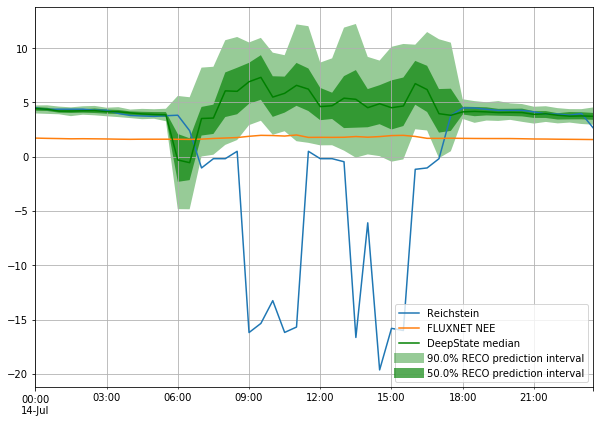

53


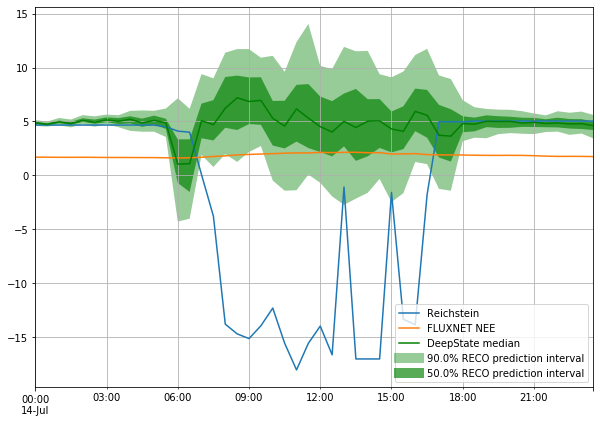

54


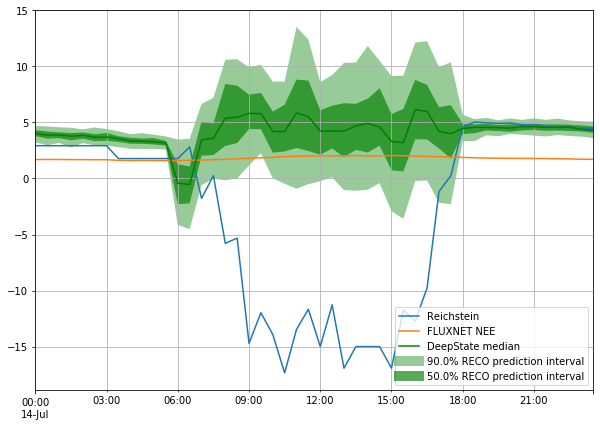

55


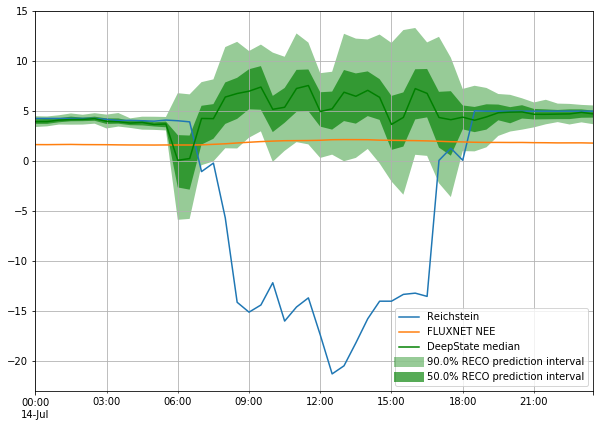

56


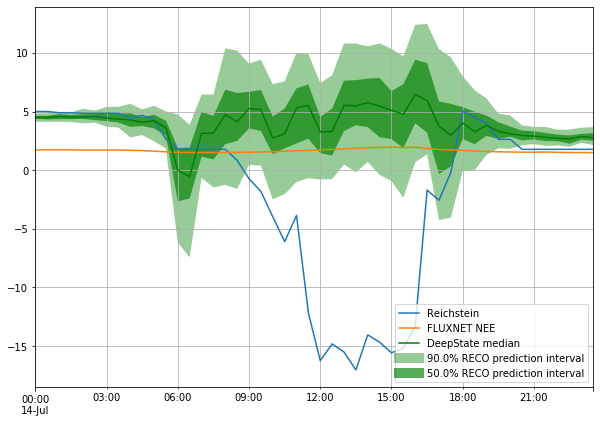

57


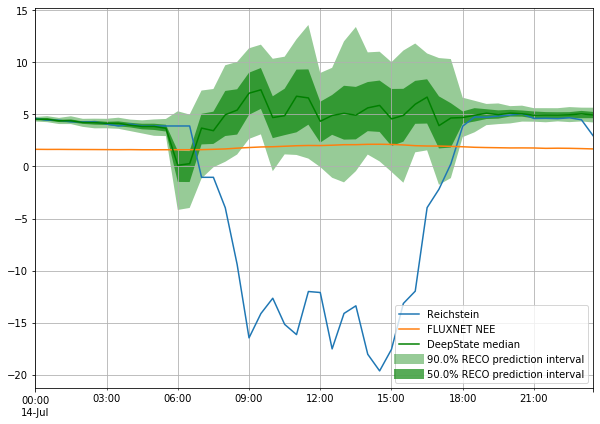

58


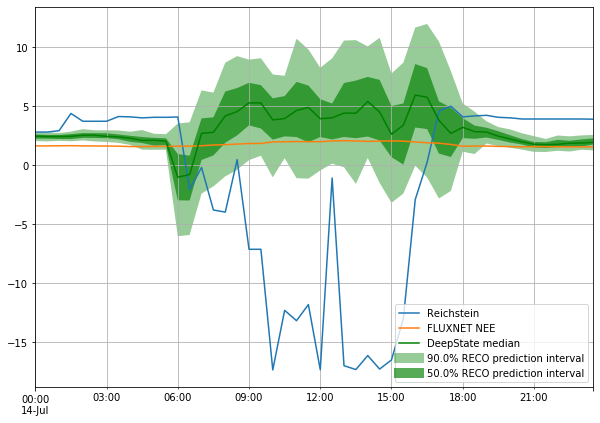

59


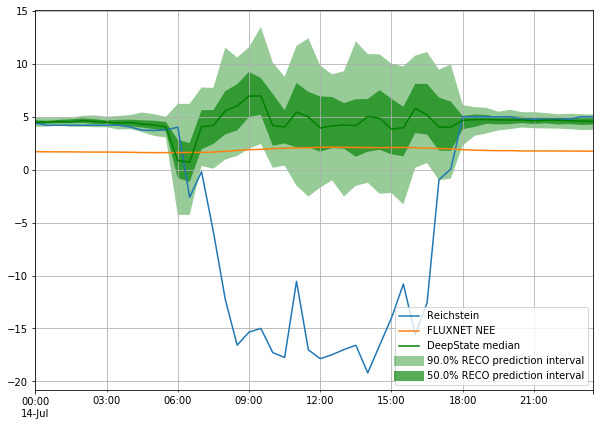

60


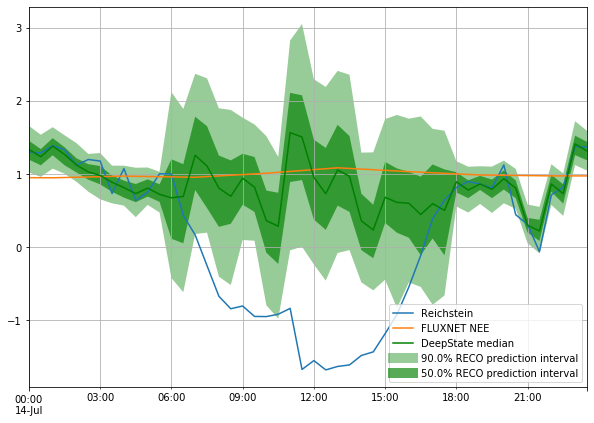

61


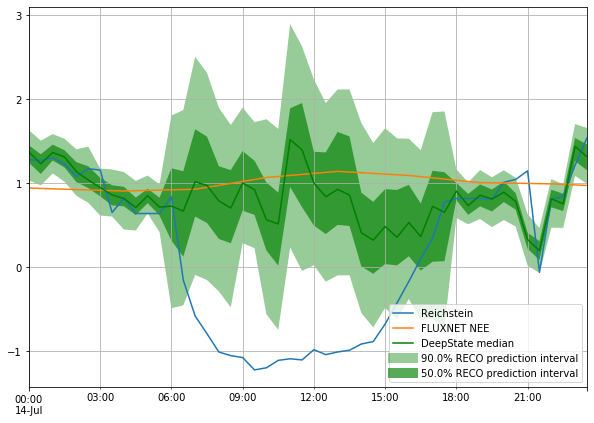

62


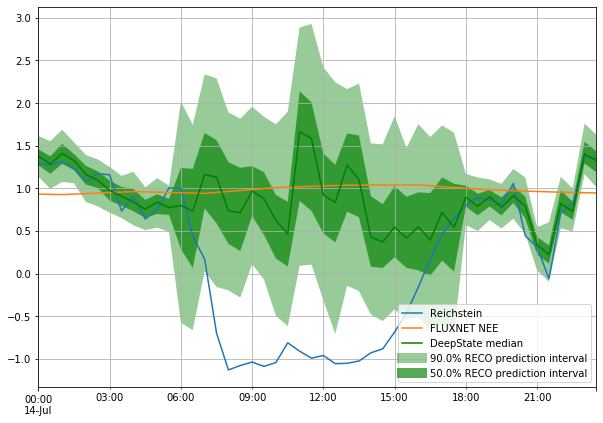

63


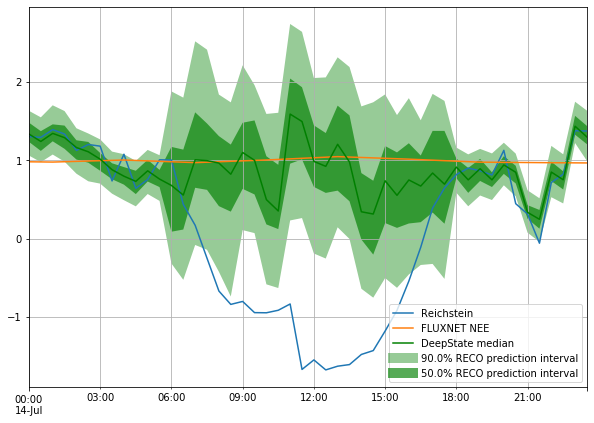

64


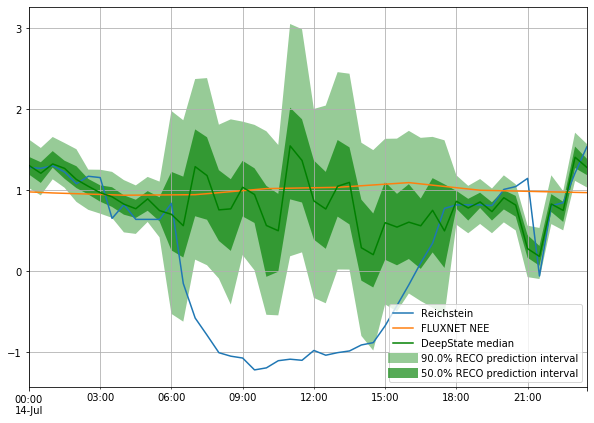

65


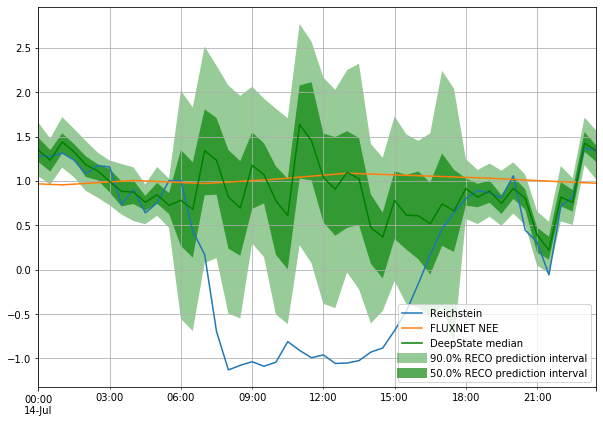

66


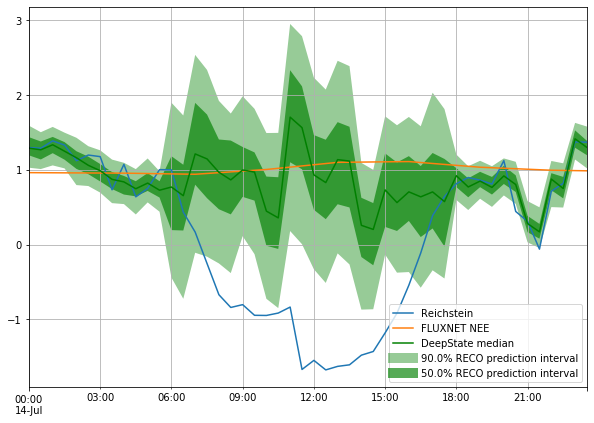

67


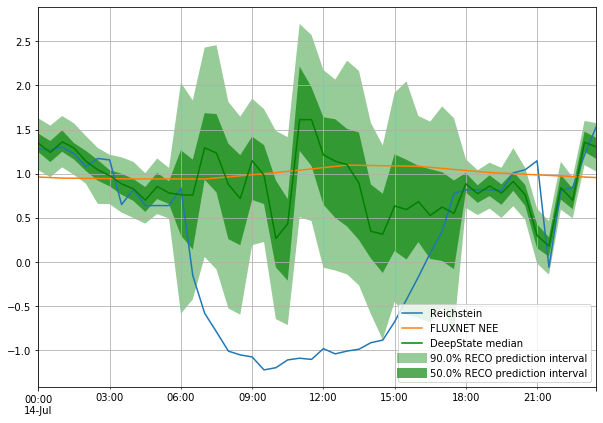

68


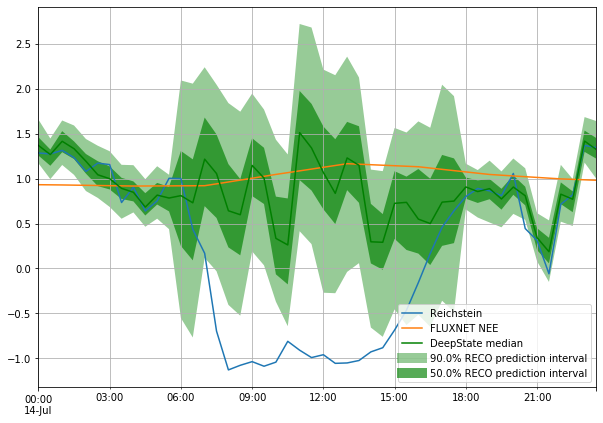

69


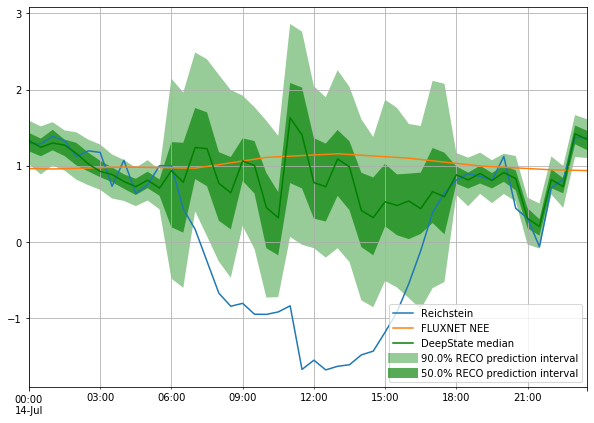

In [35]:
#plotting the forecast
ind_list = range(0,10)
k=0
for i in ind_list:
    print(i)
    plot_prob_forecasts(tss_baseline, tss_baseline_NEE, forecasts, i)

In [ ]:
#using the default Evaluator
evaluator = MyEvaluator(quantiles=[0.1, 0.25, 0.5, 0.75, 0.9])

In [46]:
#modifying the Evaluator by adding more evaluation metrics
from gluonts.evaluation import Evaluator
from gluonts.model.forecast import Forecast, Quantile
from gluonts.gluonts_tqdm import tqdm
from typing import (
    Any,
    Dict,
    Iterable,
    Iterator,
    List,
    Optional,
    Tuple,
    Union,
    Callable,
)

class MyEvaluator(Evaluator):

    @staticmethod
    def mad(target, forecast):
        if isinstance(target, np.ma.MaskedArray):
            target = target.filled()
        return np.median(np.abs(target - forecast))
    
    def crps_ens(self, target, forecast):
        if isinstance(target, np.ma.MaskedArray):
            target = target.filled()
        return np.mean(ps.crps_ensemble(target, forecast))
    
    def uncertainty_cost_fct(self, target, forecast, variance_forecast):
        return np.sum((target - forecast)**2 / variance_forecast)

    def get_metrics_per_ts(
        self, time_series: Union[pd.Series, pd.DataFrame], forecast: Forecast) -> Dict[str, Union[float, str, None]]:
        pred_target = np.array(self.extract_pred_target(time_series, forecast))
        pred_target = np.ma.masked_invalid(pred_target)

        # required for seasonal_error and owa calculation
        past_data = np.array(self.extract_past_data(time_series, forecast))
        past_data = np.ma.masked_invalid(past_data)

        try:
            mean_fcst = forecast.mean
            variance_fcst = np.mean((forecast.samples - forecast.mean)**2)
        except:
            mean_fcst = None
            variance_fcst = None
        median_fcst = forecast.quantile(0.5)
        seasonal_error = self.seasonal_error(past_data, forecast)
        # For MSIS: alpha/2 quantile may not exist. Find the closest.
        lower_q = min(
            self.quantiles, key=lambda q: abs(q.value - self.alpha / 2)
        )
        upper_q = min(
            reversed(self.quantiles),
            key=lambda q: abs(q.value - (1 - self.alpha / 2)),
        )

        metrics = {
            "item_id": forecast.item_id,
            "MSE": self.mse(pred_target, mean_fcst)
            if mean_fcst is not None
            else None,
            "MSE_1d": self.mse(pred_target[:48], mean_fcst[:48])
            if mean_fcst is not None
            else None,
            "abs_error": self.abs_error(pred_target, median_fcst),
            "abs_target_sum": self.abs_target_sum(pred_target),
            "abs_target_mean": self.abs_target_mean(pred_target),
            "seasonal_error": seasonal_error,
            "MASE": self.mase(pred_target, median_fcst, seasonal_error),
            "MAPE": self.mape(pred_target, median_fcst),
            "CRPS": self.crps_ens(pred_target, mean_fcst),
            "COSTF": self.uncertainty_cost_fct(pred_target, mean_fcst, variance_fcst),
            "MAD": self.mad(pred_target, mean_fcst),
            "sMAPE": self.smape(pred_target, median_fcst),
            "OWA": np.nan,  # by default not calculated
            "MSIS": self.msis(
                pred_target,
                forecast.quantile(lower_q.value),
                forecast.quantile(upper_q.value),
                seasonal_error,
                self.alpha,
            ),
        }

        if self.calculate_owa:
            metrics["OWA"] = self.owa(
                pred_target,
                median_fcst,
                past_data,
                seasonal_error,
                forecast.start_date,
            )

        for quantile in self.quantiles:
            forecast_quantile = forecast.quantile(quantile.value)

            metrics[quantile.loss_name] = self.quantile_loss(
                pred_target, forecast_quantile, quantile.value
            )
            metrics[quantile.coverage_name] = self.coverage(
                pred_target, forecast_quantile
            )

        return metrics

    def get_aggregate_metrics(self, metric_per_ts: pd.DataFrame) -> Tuple[Dict[str, float], pd.DataFrame]:
        agg_funs = {
            "MSE": "mean",
            "MSE_1d": "mean",
            "abs_error": "sum",
            "abs_target_sum": "sum",
            "abs_target_mean": "mean",
            "seasonal_error": "mean",
            "MASE": "mean",
            "MAPE": "mean",
            "CRPS": "mean",
            "COSTF": "mean",
            "MAD": "mean",
            "sMAPE": "mean",
            "OWA": "mean",
            "MSIS": "mean",
        }
        for quantile in self.quantiles:
            agg_funs[quantile.loss_name] = "sum"
            agg_funs[quantile.coverage_name] = "mean"

        assert (
            set(metric_per_ts.columns) >= agg_funs.keys()
        ), "The some of the requested item metrics are missing."

        totals = {
            key: metric_per_ts[key].agg(agg) for key, agg in agg_funs.items()
        }

        # derived metrics based on previous aggregate metrics
        totals["RMSE"] = np.sqrt(totals["MSE"])

        flag = totals["abs_target_mean"] == 0
        totals["NRMSE"] = np.divide(
            totals["RMSE"] * (1 - flag), totals["abs_target_mean"] + flag
        )

        flag = totals["abs_target_sum"] == 0
        totals["ND"] = np.divide(
            totals["abs_error"] * (1 - flag), totals["abs_target_sum"] + flag
        )

        all_qLoss_names = [
            quantile.weighted_loss_name for quantile in self.quantiles
        ]
        for quantile in self.quantiles:
            totals[quantile.weighted_loss_name] = np.divide(
                totals[quantile.loss_name], totals["abs_target_sum"]
            )

        totals["mean_wQuantileLoss"] = np.array(
            [totals[ql] for ql in all_qLoss_names]
        ).mean()

        totals["MAE_Coverage"] = np.mean(
            [
                np.abs(totals[q.coverage_name] - np.array([q.value]))
                for q in self.quantiles
            ]
        )
        return totals, metric_per_ts

In [203]:
#evaluating DeepState nighttime Reco estimation w.r.t. fluxnet NEE night
evaluator = MyEvaluator(quantiles=[0.1, 0.25, 0.5, 0.75, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 180/180 [00:00<00:00, 387.96it/s]WARNING:root:multiple 30 does not divide base seasonality 1.Falling back to seasonality 1



In [22]:
#evaluating fluxnet Reco estimation w.r.t. fluxnet NEE night
evaluator = MyEvaluator(quantiles=[0.1, 0.25, 0.5, 0.75, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(fluxnet_Reco_forecast), num_series=len(tss_baseline))

Running evaluation: 100%|██████████| 480/480 [00:00<00:00, 7140.00it/s]WARNING:root:multiple 30 does not divide base seasonality 1.Falling back to seasonality 1



In [204]:
#error metrics
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 0.6734946788357641,
    "MSE_1d": 0.6734946788357641,
    "abs_error": 2341.663400530815,
    "abs_target_sum": 11388.726524353027,
    "abs_target_mean": 2.6362792880446824,
    "seasonal_error": 0.1853261894161002,
    "MASE": 3.7318799404308374,
    "MAPE": 0.36522468091562943,
    "CRPS": 5.000000100204387e+19,
    "COSTF": 17.359286658962567,
    "MAD": 5.000000100204387e+19,
    "sMAPE": 0.33481545806719737,
    "OWA": NaN,
    "MSIS": 48.56241719801415,
    "QuantileLoss[0.1]": 1593.6823356389998,
    "Coverage[0.1]": 0.13912037037037037,
    "QuantileLoss[0.25]": 2213.908525187522,
    "Coverage[0.25]": 0.21712962962962967,
    "QuantileLoss[0.5]": 2341.6634176522493,
    "Coverage[0.5]": 0.500462962962963,
    "QuantileLoss[0.75]": 2008.3759682923555,
    "Coverage[0.75]": 0.766435185185185,
    "QuantileLoss[0.9]": 1309.4800537884234,
    "Coverage[0.9]": 0.8525462962962965,
    "RMSE": 0.8206672156457598,
    "NRMSE": 0.31129752426741,
    "ND": 0.20561240060717